This module is meant to run a bunch of tests comparing the Fourier matrix elements of AMR waves on some arbitrary AMR grid. I recommend comparing the results in cell 13 between even and odd numbers for `refCells`.

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
from fractions import Fraction
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
from fractions import Fraction


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

This cell is for all the input variables. `nh` is the number of coarse cells; `refCells` is the number of coarse cells on which you want to refine.

In [2]:
nh = 32
refRatio = 2
refCells = 13
Hans = False
prenorm = False

omega = BT.Grid(nh)
finehalf = list(np.arange(refCells))
omega.AddPatch(refRatio, finehalf)

In [3]:
def KSpace(omega):
    nh_min = omega.nh_min
    degFreed = omega.degFreed
    x = omega.xNode
    hs = omega.h
    ks = np.arange(nh_min + 1)[1:]
    sj = np.zeros((2 * degFreed, nh_min), float)
    for j in range(degFreed):
        sj[2 * j, :] = np.cos(2. * np.pi * ks * (x[j] + (hs[j] / 2.))) * np.sin(np.pi * hs[j] * ks) / (np.pi * hs[j] * ks)
        sj[(2 * j) + 1, :] = np.sin(2. * np.pi * ks * (x[j] + (hs[j] / 2.))) * np.sin(np.pi * hs[j] * ks) / (np.pi * hs[j] * ks)
    Sjcos = sum(abs(sj[::2]), axis = 0)
    Sjsin = sum(abs(sj[1::2]), axis = 0)
    return ks, sj, Sjcos, Sjsin

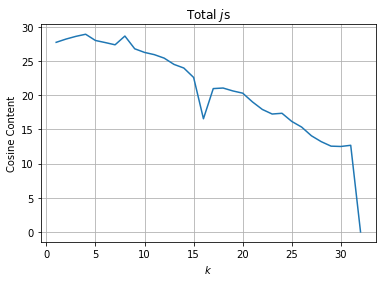

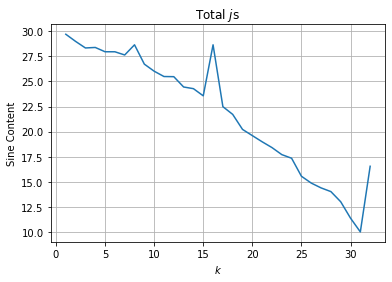

[2.77282531e+01 2.82051092e+01 2.85990583e+01 2.89115863e+01 2.79995865e+01 2.76934144e+01 2.73672147e+01 2.86478898e+01 2.67846371e+01 2.62534479e+01 2.59265554e+01 2.54178687e+01 2.45019320e+01 2.39711682e+01 2.25916642e+01 1.65521141e+01 2.09627706e+01 2.10450854e+01 2.06186459e+01 2.02924926e+01 1.90069644e+01 1.79109688e+01 1.72424979e+01 1.73520380e+01 1.61569492e+01 1.53358104e+01 1.40589908e+01 1.31991131e+01 1.25441967e+01 1.24970672e+01 1.26693760e+01 3.89899935e-14]
[29.69943086 28.98576534 28.33302375 28.38419321 27.95589326 27.95363317 27.63540123 28.64788976 26.72329172 26.01978095 25.49004787 25.47427703 24.44784646 24.28082414 23.56717884 28.64788976 22.48928263 21.719038   20.22383821 19.60608454 18.99118026 18.41459926 17.71411528 17.35203799 15.55988588 14.87984014 14.40027196 14.0319933  13.02108496 11.3882054  10.01712868 16.55211408]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]



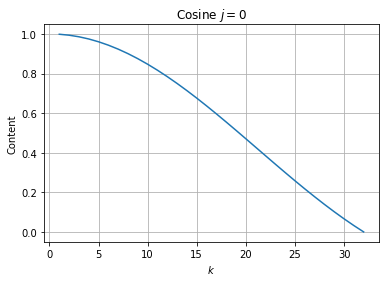

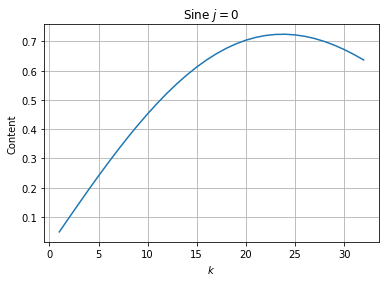

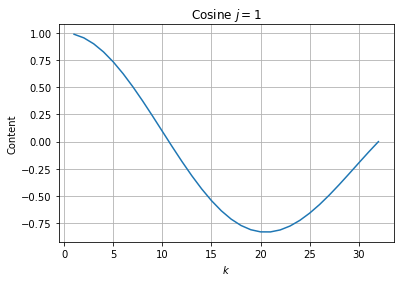

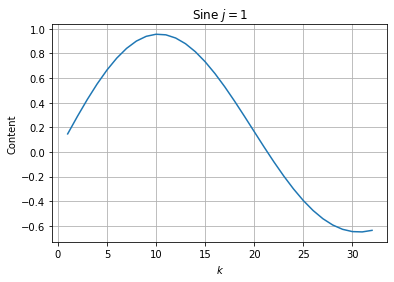

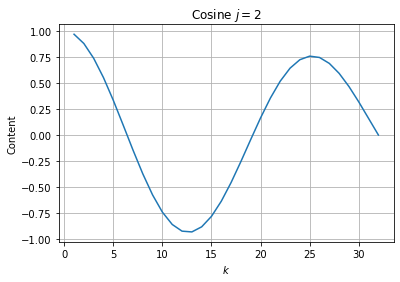

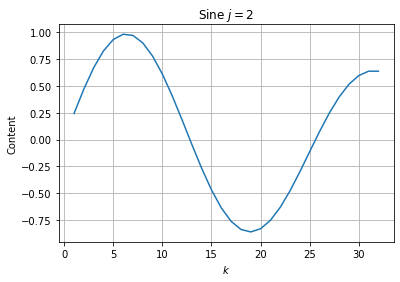

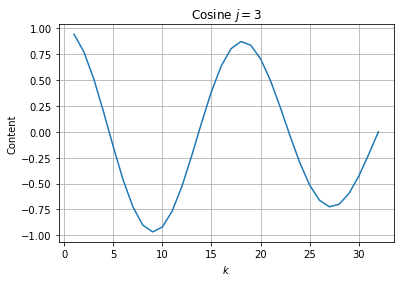

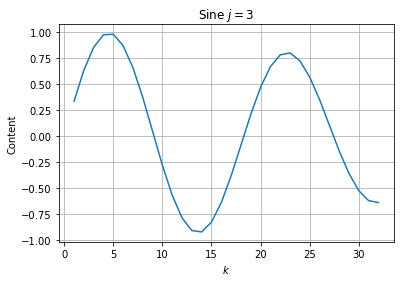

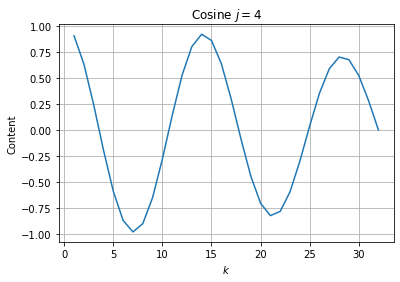

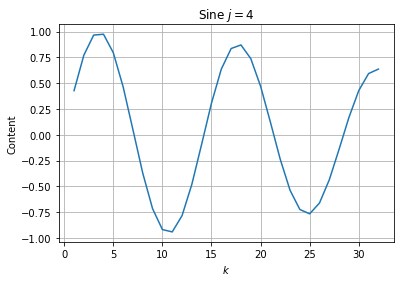

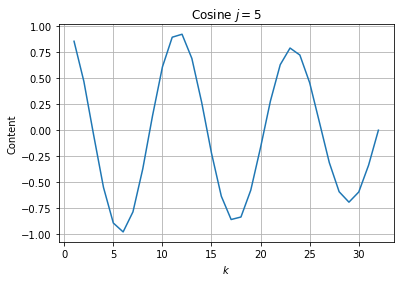

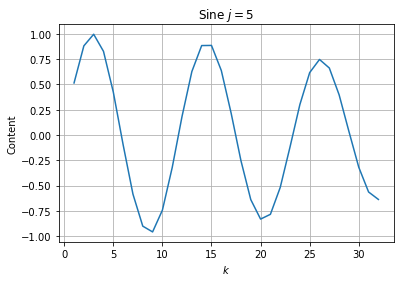

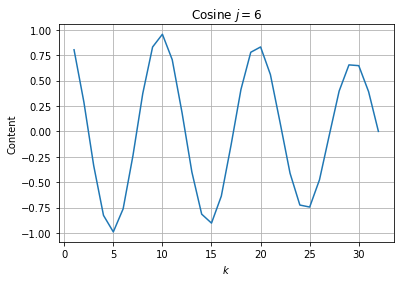

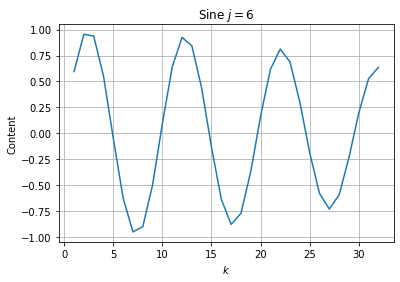

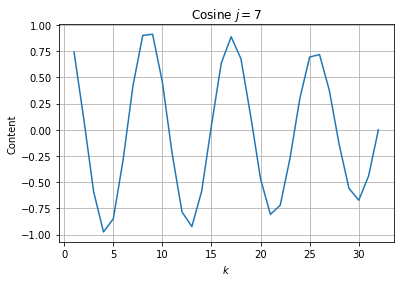

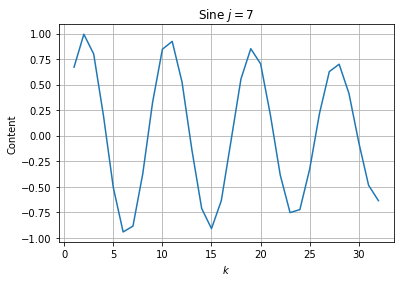

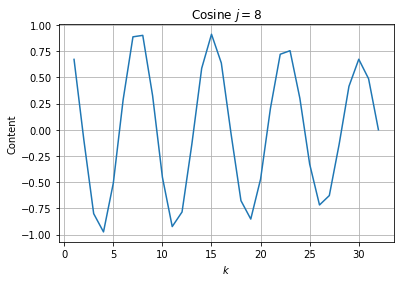

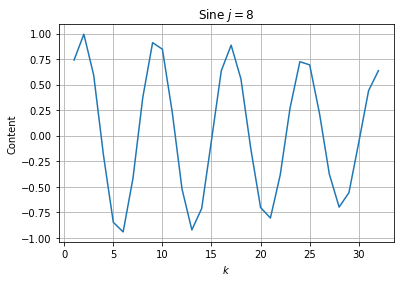

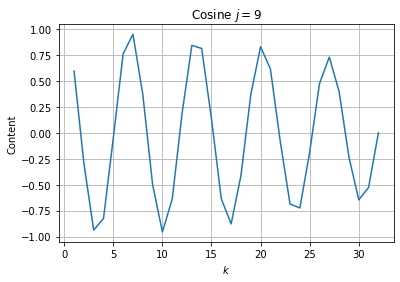

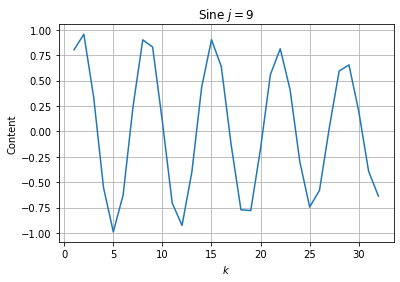

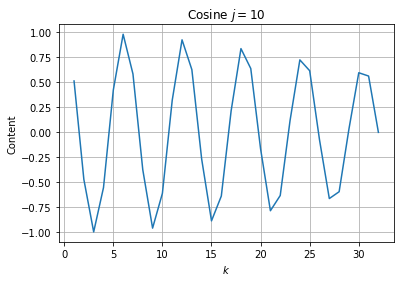

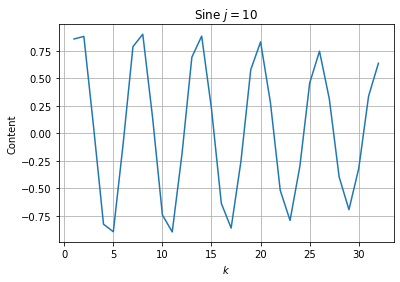

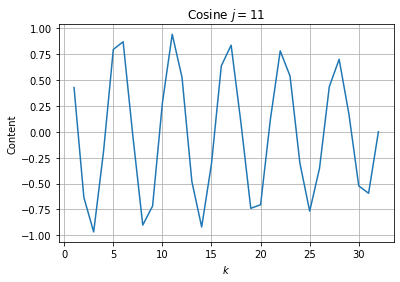

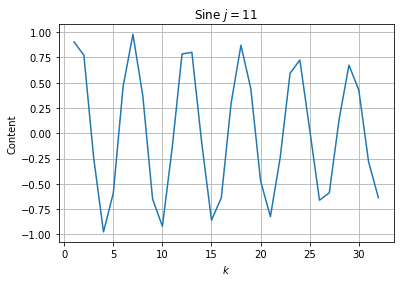

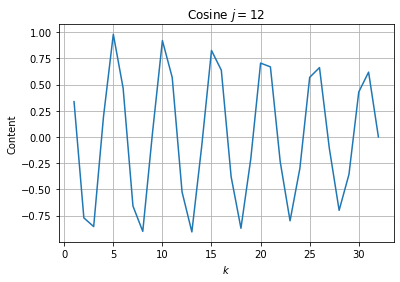

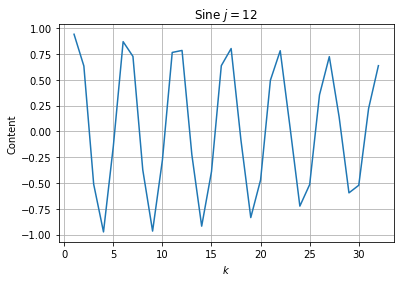

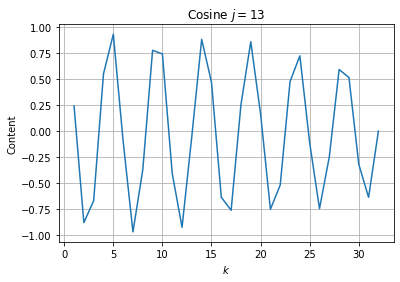

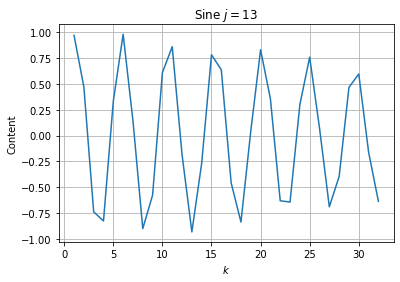

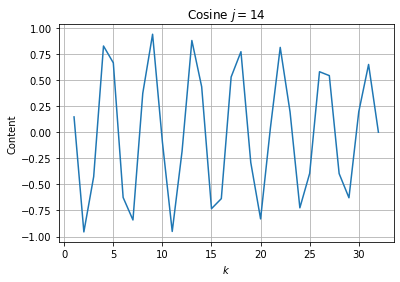

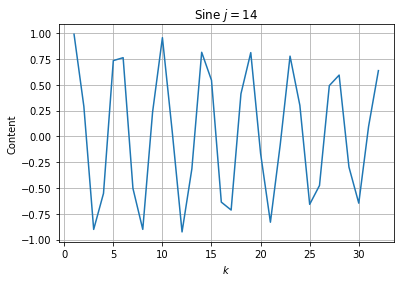

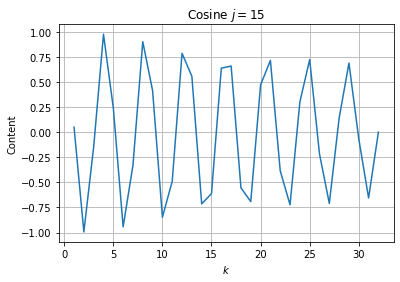

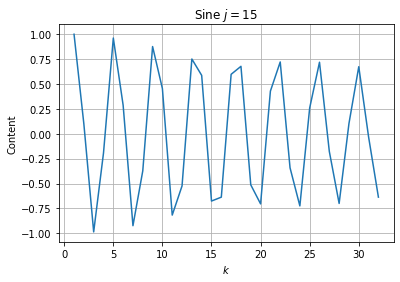

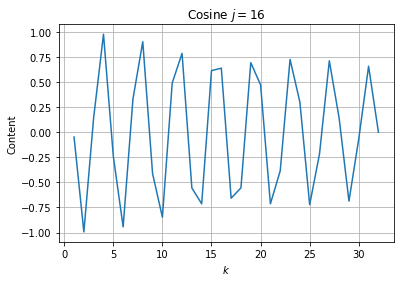

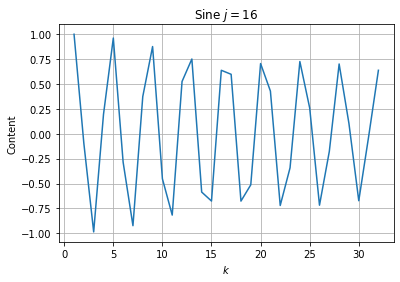

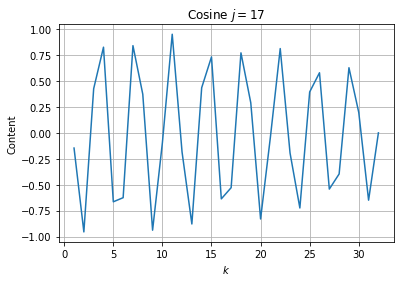

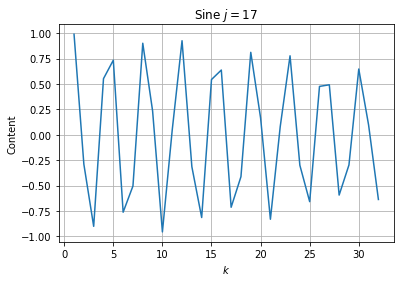

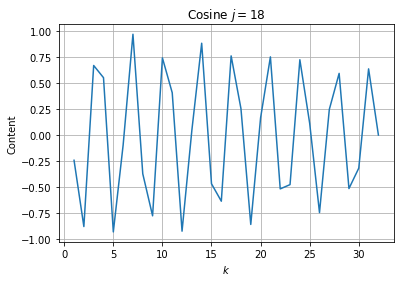

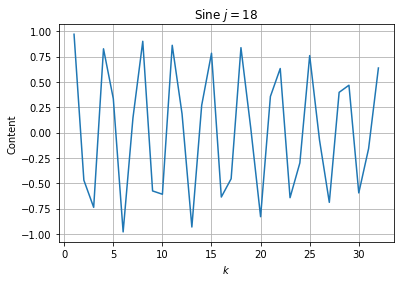

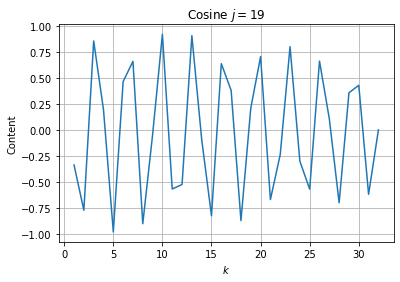

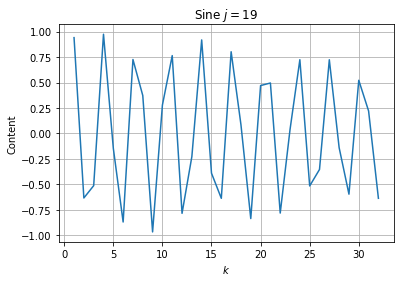

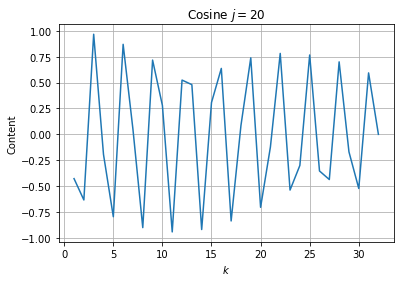

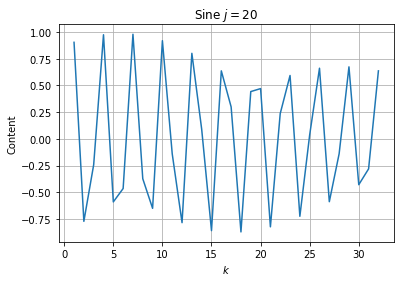

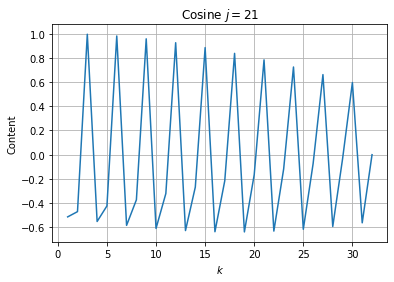

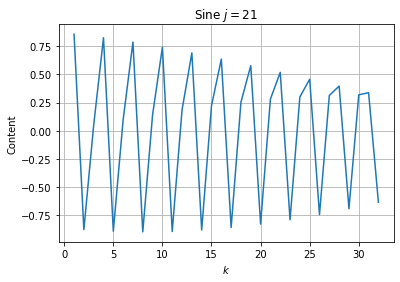

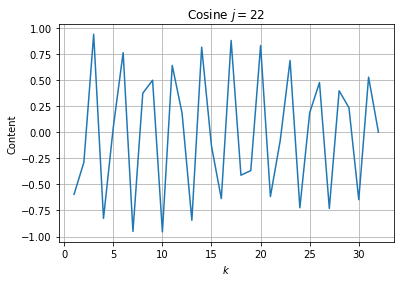

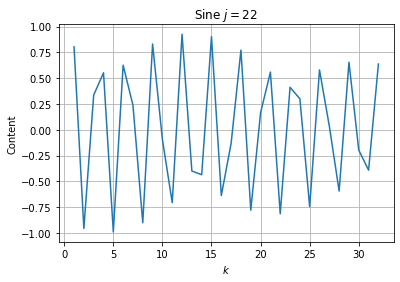

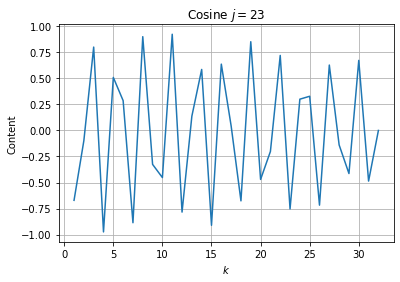

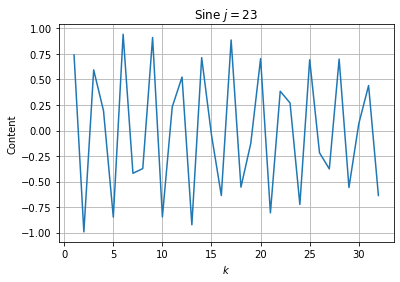

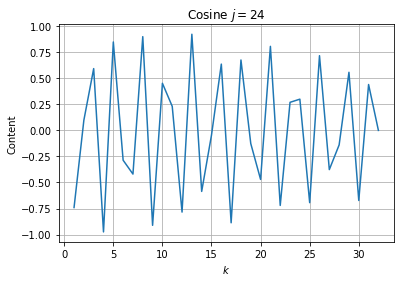

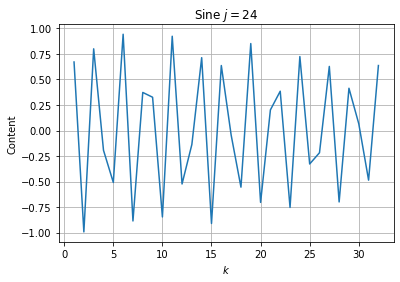

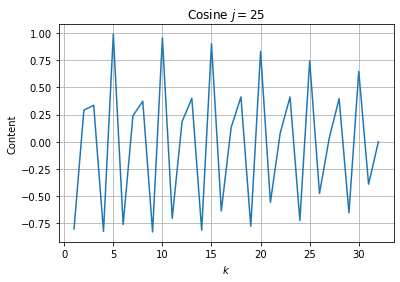

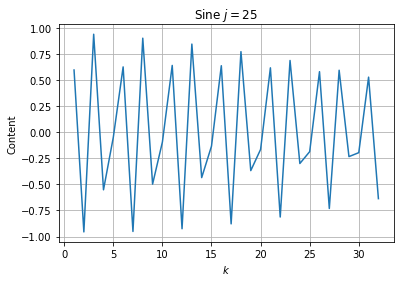

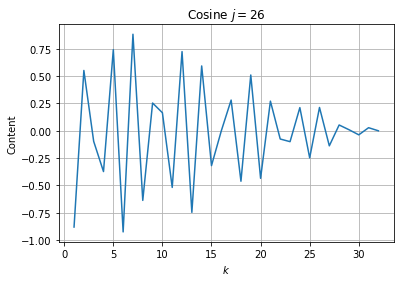

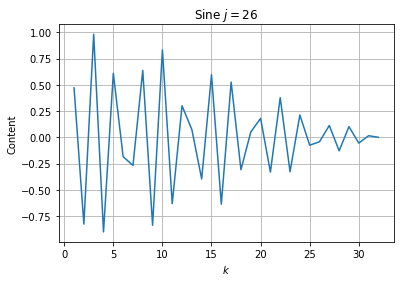

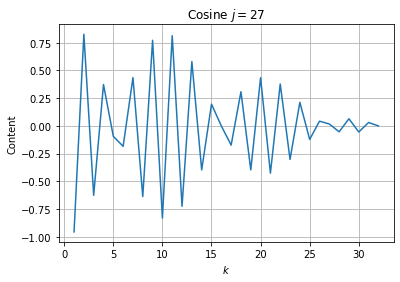

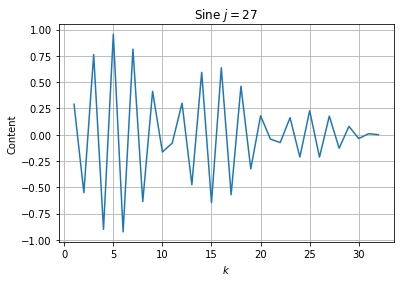

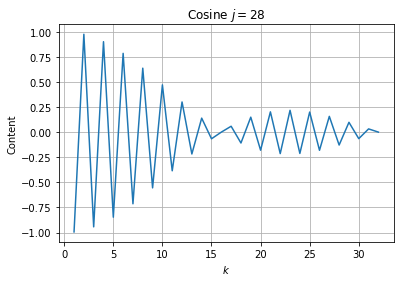

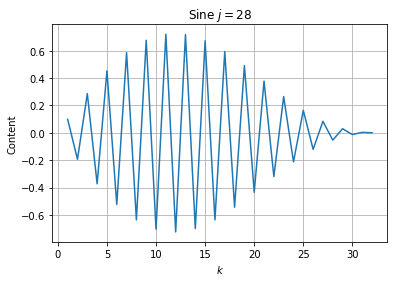

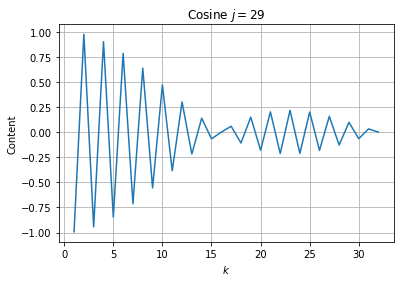

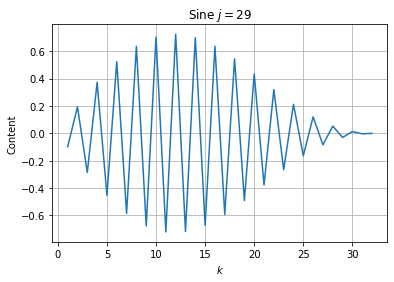

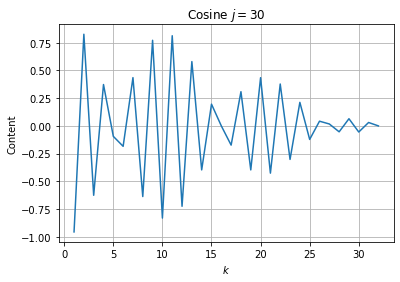

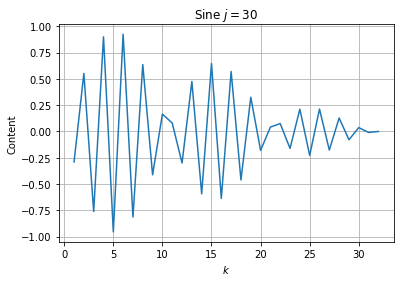

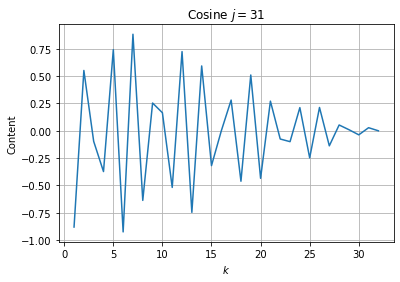

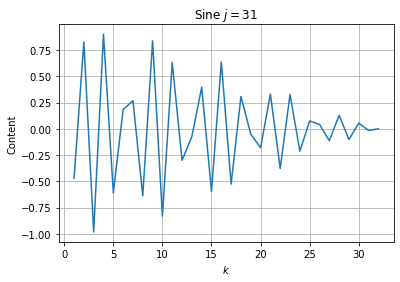

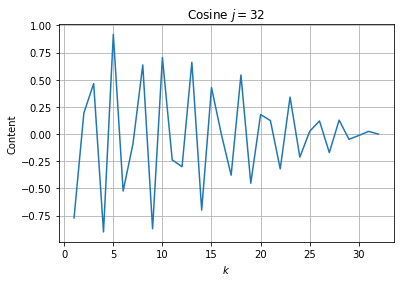

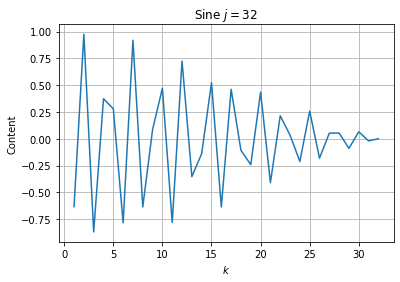

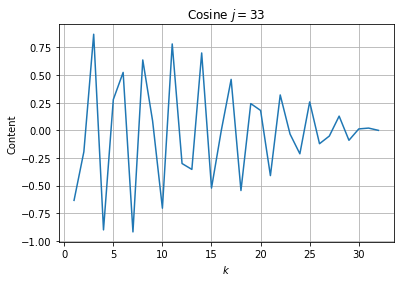

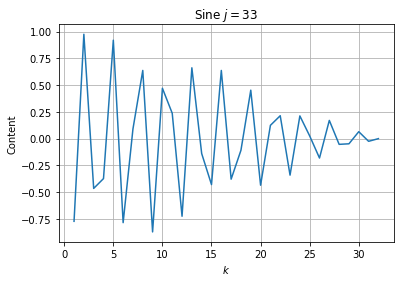

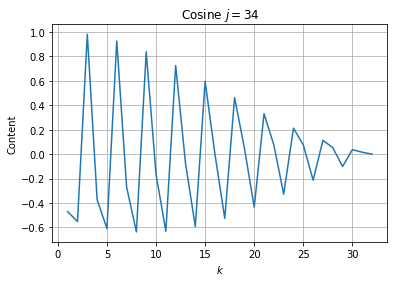

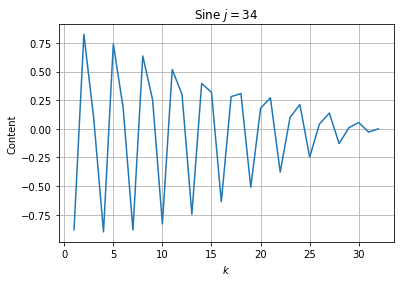

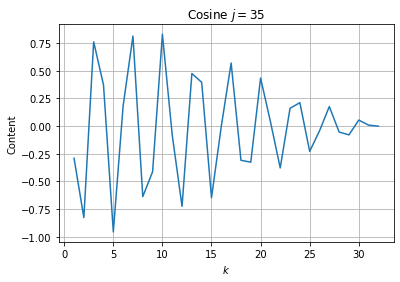

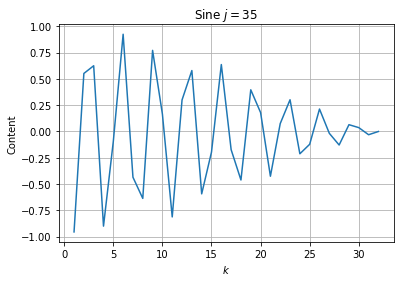

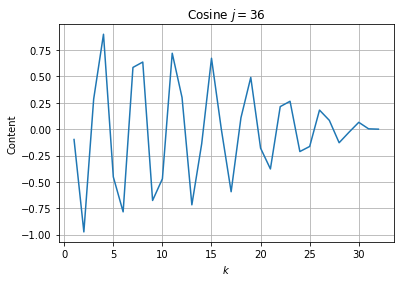

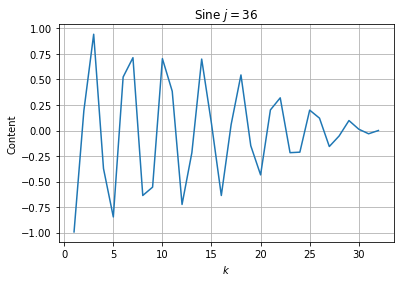

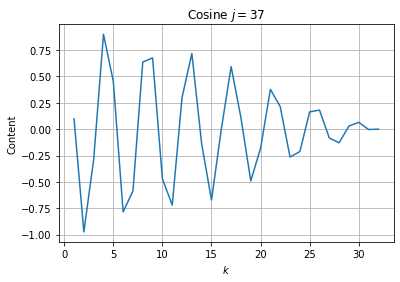

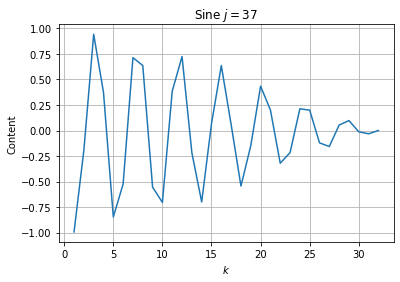

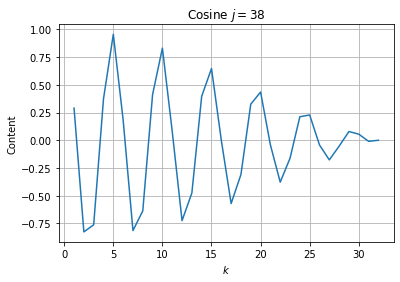

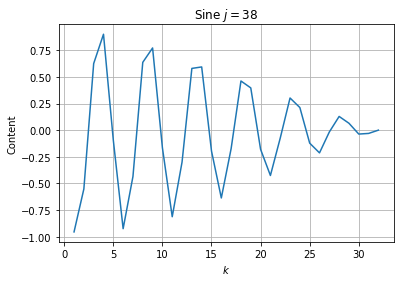

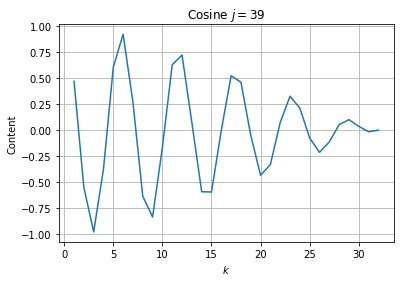

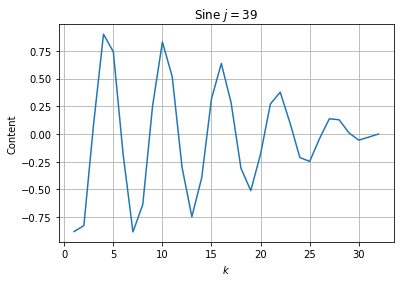

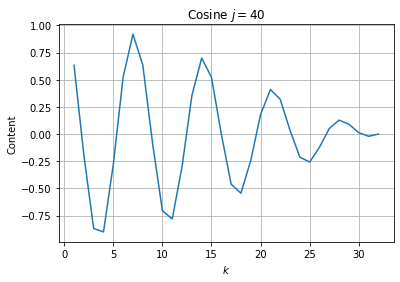

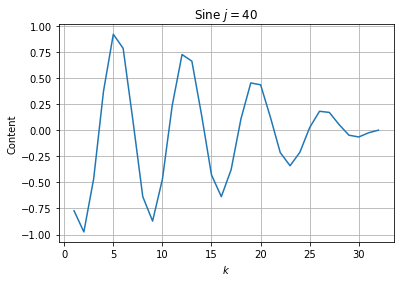

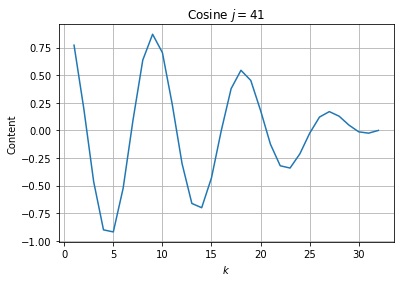

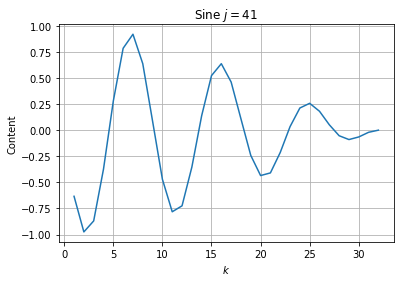

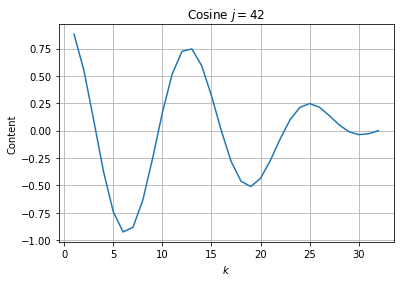

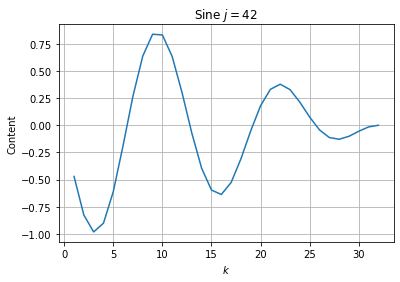

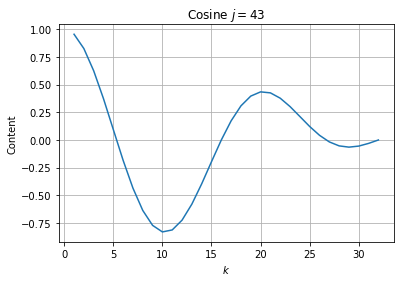

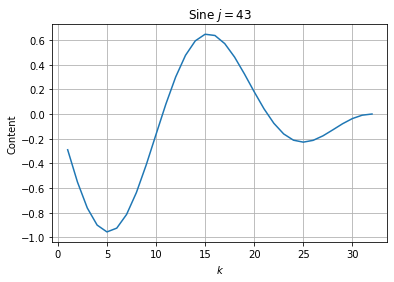

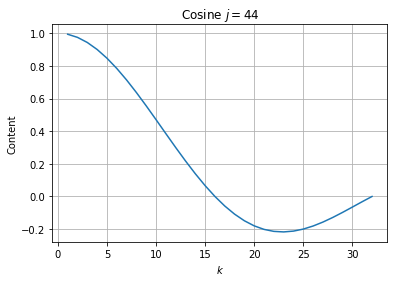

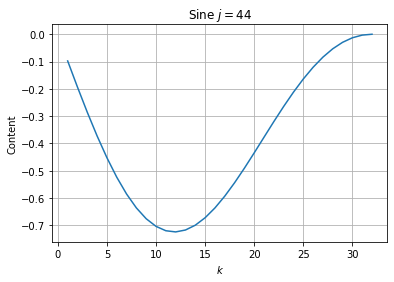

In [4]:
degFreed = omega.degFreed

ks, sj, Sjcos, Sjsin = KSpace(omega)
fig, ax = plt.subplots()#figsize = [12, 10])
plt.plot(ks, Sjcos)
plt.title(r'Total $j$s')
plt.xlabel(r'$k$')
plt.ylabel('Cosine Content')
ax.grid(True, zorder = 0)
plt.show()

ks, sj, Sjcos, Sjsin = KSpace(omega)
fig, ax = plt.subplots()#figsize = [12, 10])
plt.plot(ks, Sjsin)
plt.title(r'Total $j$s')
plt.xlabel(r'$k$')
plt.ylabel('Sine Content')
ax.grid(True, zorder = 0)
plt.show()

print(Sjcos)
print(Sjsin)
print(ks)
print('')
for j in range(degFreed):
    fig, ax = plt.subplots()#figsize = [12, 10])
    plt.plot(ks, sj[2 * j, :])
    plt.title(r'Cosine $j = %d$' %j)
    plt.xlabel(r'$k$')
    plt.ylabel('Content')
    ax.grid(True, zorder = 0)
    # saveName = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/xvsx_0_' + str(nt)
    # fig.savefig(saveName + '.png', bbox_inches = 'tight')
    plt.show()
    
    fig, ax = plt.subplots()#figsize = [12, 10])
    plt.plot(ks, sj[(2 * j) + 1, :])
    plt.title(r'Sine $j = %d$' %j)
    plt.xlabel(r'$k$')
    plt.ylabel('Content')
    ax.grid(True, zorder = 0)
    # saveName = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/xvsx_0_' + str(nt)
    # fig.savefig(saveName + '.png', bbox_inches = 'tight')
    plt.show()

In [5]:
# ----------------------------------------------------------------------------------------------------------------
# Function: Normalization
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function finds the inner product of an input matrix with itself, outputs that inner product matrix, and
# then prints to screen a bunch of tests on that inner product matrix. The first test is for symmetry; if WTW is
# symmetric, then this should be a matrix of zeros. The next is the inverse. The next is the symmetry of the
# inverse. The next two are WTW left- and right-multiplied by its inverse. The last three are the determinant,
# eigenvalues, and eigenvectors of WTW. If WTW contains an eigenvalue of zero, the eigenvector corresponding to
# that eigenvalue is also output to screen; this consitutes the nullspace of WTW.
# ----------------------------------------------------------------------------------------------------------------
# Input:
#
# waves               (N x M) real        Matrix of wave vectors
# ----------------------------------------------------------------------------------------------------------------
# Output:
#
# WTWinv              (M x M) real        A positive non negative number given by the user
# ----------------------------------------------------------------------------------------------------------------

In [6]:
def TestThings(WTW):
    det = LA.det(WTW)
    sym = WTW - WTW.transpose()
    WTWinv = LA.inv(WTW)
#     WWTW = waves @ WTWinv
    syminv = WTWinv - WTWinv.transpose()
    ID1 = WTWinv @ WTW
    ID2 = WTW @ WTWinv
    eigvals, eigvecs = LA.eig(WTW)
    eigvals = abs(np.round(eigvals, 12))
    condition = False
    if (any(eigvals == 0)):
        condition = True
        index = np.where(abs(np.round(eigvals, 12)) == 0)[0]
        zeroVec = eigvecs[:, index]
    
#     print('W(W^TW)^-1 =')
#     print(np.round(WWTW, 14))
    print('')
    print('symmetry of W^TW:')
    print(np.round(sym, 14))
    print('')
    print('(W^TW)^-1:')
    print(np.round(WTWinv, 14))
    print('')
    print('symmetry of (W^TW)^-1:')
    print(np.round(syminv, 14))
    print('')
    print('identity 1:')
    print(np.round(ID1, 14))
    print('')
    print('identity 2:')
    print(np.round(ID2, 14))
    print('')
    print('determinant =', det)
    print('')
    print('eigenvalues:')
    print(np.round(eigvals, 14))
    print('')
    print('eigenvectors:')
    print(eigvecs)#np.round(eigvecs, 12))
    if (condition):
        print('')
        print('nullspace of W^TW:')
        print(np.round(zeroVec, 12))
    print('')
    
    return WTWinv

In [7]:
def Normalization(waves):
    WTW = waves.transpose() @ waves
    print('')
    print('W^TW:')
    print(np.round(WTW, 14))
    WTWinv = TestThings(WTW)
    return WTWinv

In [8]:
# ----------------------------------------------------------------------------------------------------------------
# Function: DotEach
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function finds the inner products of each pair of vectors in the input matrix and prints them to screen.
# ----------------------------------------------------------------------------------------------------------------
# Input:
#
# waves               (N x M) real        Matrix of wave vectors
# ----------------------------------------------------------------------------------------------------------------

In [9]:
def DotEach(waves):
    iters = np.shape(waves)[1]
    print(np.round(waves, 14))
    print('')
    for k in range(iters):
        for j in range(k, iters):
            dotprod = np.round(waves[:, k].transpose() @ waves[:, j], 14)
            print(str(k) + ' dot ' + str(j) + ': ' + str(dotprod))
            print('')
    return

In [10]:
def Prenormalize(omega, waves):
    degFreed = omega.degFreed
    hs = omega.h
    nhs = omega.nh
    nh_max= omega.nh_max
    dim = np.shape(waves)
    newWaves = np.zeros(dim, float)
    print('waves:')
    print(waves)
    print('')
    for nh in nhs:
        alias = int(nh_max / nh)
        omegah = BT.Grid(nh, alias = alias)
        wavesh = WT.MakeWaves(omegah)
        norm = np.diag(np.diag(np.round(wavesh.transpose() @ wavesh, 14) ** -1))
        norm[norm == inf] = 0#np.round(LA.inv(prenorm), 14)
        print('nh:')
        print(nh)
        print('')
        h = 1. / nh
        stripLoc = np.where(hs == h)[0]
        antipiece = waves + 0
        antipiece[stripLoc, :] = 0
        piece = (waves - antipiece) @ norm
        print('antipiece:')
        print(antipiece)
        print('')
        print('piece:')
        print(piece)
        print('')
        print('norm:')
        print(norm)
        print('')
        newWaves = newWaves + piece
    waves = newWaves
    print('newWaves:')
    print(waves)
    print('')
    return

This cell instantiates the AMR and the fine grid and finds the AMR and fine waves as well as the nullspace.

In [11]:
finehalf = list(np.arange(refCells))
omega = BT.Grid(nh)
omega.AddPatch(refRatio, finehalf)
nh_max = omega.nh_max
degFreed = omega.degFreed
omegaF = BT.Grid(nh_max)

waves = WT.MakeWaves(omega)
wavesF = WT.MakeWaves(omegaF)
nullspace = OT.FindNullspace(omega, waves, Hans = Hans)
print(nullspace)
if (prenorm):
    Prenormalize(omega, waves)

wavesMod = waves @ nullspace
wavesFMod = wavesF @ nullspace
restrictOp = GTT.CoarsenOp(omega)



[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.

This cell plots the waves in the nullspace.

In [12]:
FCoefF = np.zeros(nh_max, float)
FCoefF[-1] = 1
waveformAMR = restrictOp @ wavesF @ FCoefF
FCoefAMR = FFTT.FourierCoefs(omega, wavesMod, waveformAMR)
print(FCoefAMR)
print(FCoefAMR)
# PT.PlotWaves(omega, waves = waves, nullspace = nullspace)
# PT.PlotMixedWave(omega, waves = waves, FCoefs = nullspace @ FCoefAMR)
print('\n\n\n\n\n\n\n\n\n\n')
# PT.PlotWaves(omegaF, waves = wavesF)

AttributeError: 'Grid' object has no attribute 'transpose'

In [ ]:
# degFreed = omega.degFreed
# FCoefs1 = np.zeros(degFreed, float)
# FCoefs2 = FCoefs1 + 0
# FCoefs1[-2] = 1
# FCoefs2[-1] = 1
# FCoefs = FCoefs1 - FCoefs2
# allCoefs = PT.Load(FCoefs, FCoefs1, FCoefs2)
# labels = ['FCoefs', 'FCoefs1', 'FCoefs2']
# print(FCoefs)
# PT.PlotMixedWave(omega, waves = waves, waveCoef = nullspace @ allCoefs, labels = labels, rescale = 6, yGrid = True)


In [ ]:
# w0 = waves[:, 0]
# w1 = waves[:, 1]
# print(w0.transpose() @ w1)
# hAMR = omega.h
# print(hAMR)
# print((hAMR.transpose() * w0) @ w1)
# mat = np.diag(hAMR)
# print(np.round(waves.transpose() @ mat @ waves, 14))


The results in this cell make sense to me.

In [ ]:
print('Tests on AMR Waves without Nullspace Treatment:')
normWrong = Normalization(waves)



In [ ]:
DotEach(waves)

The results in this cell do not.

In [ ]:
print('AMR Waves with Nullspace Treatment:')
print('')
print('W:')
print(wavesMod)
normAMR = Normalization(wavesMod)

# LOOK AT WHAT HAPPENS TO THE CONSTANT MODE WHEN YOU SWITCH BETWEEN THE EVEN AND ODD CASES.
print('LOOK HERE:')
print('AMR Waves with Nullspace Treatment Normalized Using This Method:\n')
print(wavesMod @ normAMR)
print('')
FCoefs = np.round(nullspace @ (waves.transpose() @ wavesMod @ normAMR).transpose(), 13)
print(FCoefs)
print('')
print(FCoefs[1, 13] ** 2)
print(Fraction(FCoefs[1, 13] ** 2))


In [ ]:
DotEach(wavesMod)

This is what I believed you asked of me.

In [ ]:
print('Fine Waves with Nullspace Treatment:')
normF = Normalization(wavesFMod)
print('AMR Waves with Nullspace Treatment Normalized Using This Method:\n')
print(wavesMod @ normF)
print((wavesMod @ normF)[:, 0])

In [ ]:
DotEach(wavesFMod)

In [ ]:
# [[ 0.        ]
#  [ 0.07396956]
#  [ 0.0306392 ]
#  [ 0.1132277 ]
#  [ 0.1132277 ]
#  [ 0.09191759]
#  [ 0.22190869]
#  [ 0.        ]
#  [ 0.32025631]
#  [-0.32025631]
#  [-0.24912485]
#  [ 0.3754923 ]
#  [-0.33404366]
#  [ 0.3464999 ]
#  [-0.52002231]]

# [[ 0.        ]
#  [ 0.03688315]
#  [ 0.08904379]
#  [-0.02590328]
#  [ 0.02590328]
#  [ 0.16559858]
#  [ 0.06859318]
#  [ 0.        ]
#  [ 0.3683307 ]
#  [-0.51486176]
#  [-0.01920905]
#  [ 0.73770533]
#  [ 0.10914531]]

# [[ 0.        ]
#  [-0.02486985]
#  [ 0.06004112]
#  [ 0.07034254]
#  [ 0.07034254]
#  [ 0.07460954]
#  [-0.03090428]
#  [ 0.        ]
#  [ 0.45891091]
#  [-0.67426232]
#  [-0.56047288]]


# [[ 0.        ]
#  [-0.01372416]
#  [ 0.00917019]
#  [-0.0119001 ]
#  [ 0.02872937]
#  [ 0.00818972]
#  [ 0.04117248]
#  [ 0.03365856]
#  [ 0.03365856]
#  [ 0.04585096]
#  [ 0.00912032]
#  [ 0.03570029]
#  [-0.01478754]
#  [ 0.01276845]
#  [-0.01910934]
#  [ 0.        ]
#  [ 0.45269843]
#  [-0.77963153]
#  [-0.42162122]]

In [ ]:
# vec = np.round(wavesMod[:, -1], 14)
# print(vec)
# norm = vec.transpose() @ vec
# print(norm)
# print(vec / norm)
# print('')

In [ ]:
print(wavesMod)
print('')
blah = TestThings(wavesMod)


In [ ]:
[[-0.        ]
 [-0.02486985]
 [ 0.06004112]
 [ 0.07034254]
 [ 0.07034254]
 [ 0.07460954]
 [-0.03090428]
 [ 0.        ]
 [ 0.45891091]
 [-0.67426232]
 [-0.56047288]]

bluh = TestThings(wavesMod.transpose())